### Cadeias de Markov


Uma cadeia de Markov, é nada mais nada menos do que um grafo de estados onde as arestas definem a probabilidade de ir de um estado para outro. Na cadeia de Markov, se assume que somente o estado atual influencia o próximo estado.
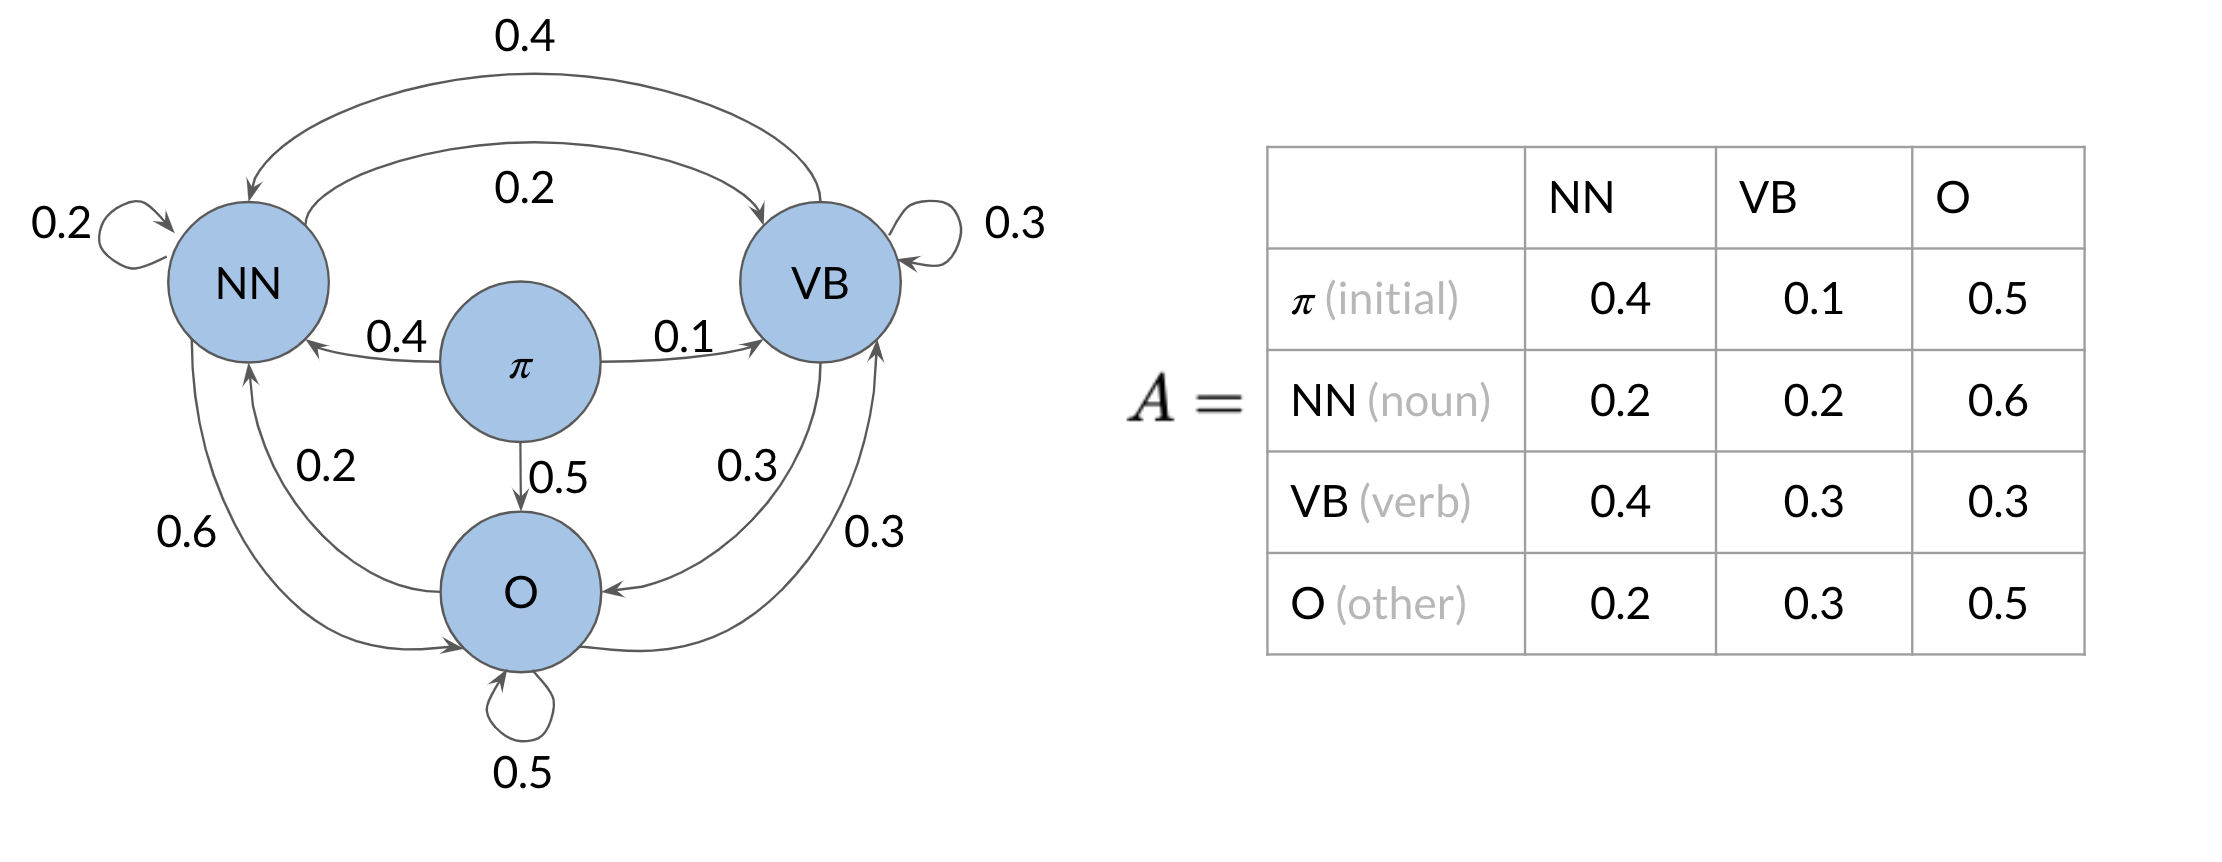

Nesse caso, os estados representam o Part of Speech Tags que são usados na linguagem para classificar as palavras, isto é "substantivo", "verbo", "advérbio", etc.

O primeiro modelo que vou aplicar aqui não vai ser o de Markov Escondido, mas sim a ideia clássica apresentada na figura acima. Ou seja, eu vou trabalhar com palavras pre-classificadas.

Para fazer a tabela de transição, devo seguir o seguinte conceito:

$$
    P(t_{i} | t_{j}) = \frac{Contagem(t_{j},t_{i})}{\sum_{k=1}^{N}{Contagem(t_{j},t_{k})}}
$$

Onde, $Contagem(t_{j},t_{i})$ é o total de ocorrências em que uma palavra de tag $t_{j}$ é seguida de uma palavra de tag 
$t_{i}$. Para não trabalharmos com probabilidade zero (soma da linha), usaremos um fator epsilon aleatório para equilibrar a matriz.

$$
    P(t_{i} | t_{j}) = \frac{Contagem(t_{j},t_{i}) + \epsilon}{\sum_{k=1}^{N}{Contagem(t_{j},t_{k}) + N\epsilon}}
$$

### Hidden Markov Model

Uma cadeia de markov escondida se baseia em estados "escondidos" das palavras. Ou seja, aqui é uma aplicação de cadeias de Markov, o que fazer com as matrizes geradas (de emissão e transição), esse modelo vai fazer uso dessas duas para dizer a probabilidade das sentenças.

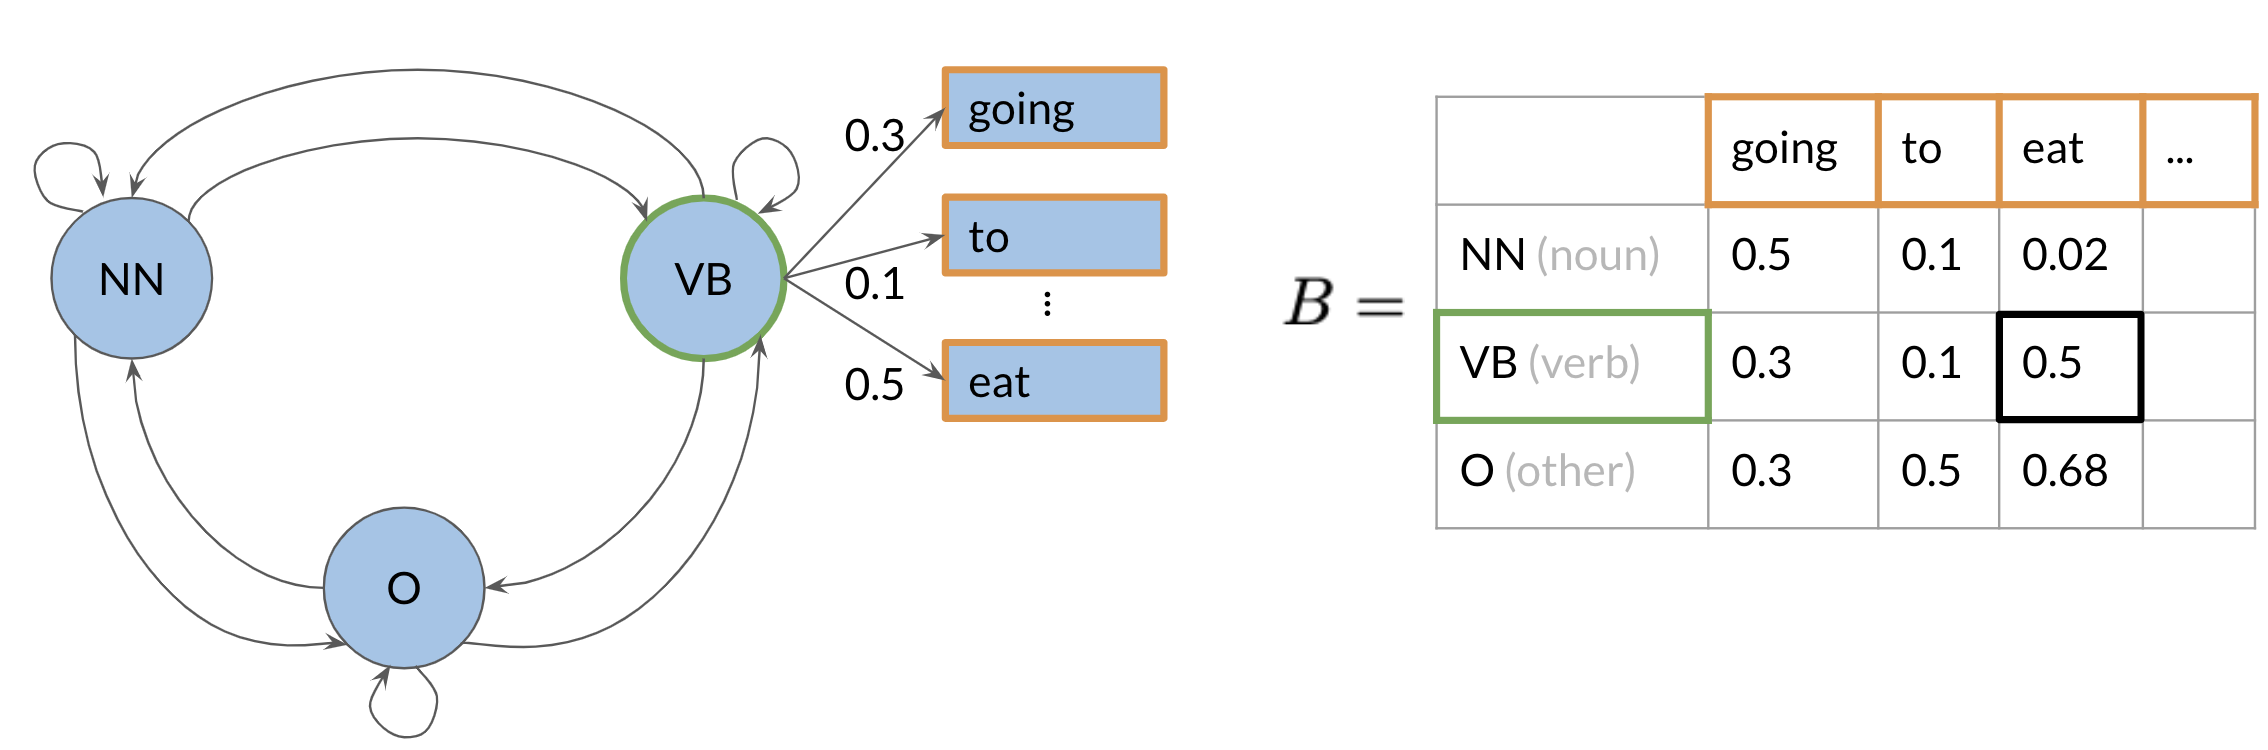

A matriz acima é chamada de matriz de emissão. Ela funciona da seguinte forma. Dada uma palavra P, quantas vezes P recebeu tag T, dado o total de palavras com tag T no corpo do texto.

$$
    P(w_{i} | t_{j}) = \frac{Contagem(t_{j},w_{i}) + \epsilon}{\sum_{k=1}^{N}{Contagem(t_{j},w_{k}) + N\epsilon}} = P(w_{i} | t_{j}) = \frac{Contagem(t_{j},w_{i}) + \epsilon}{Contagem(t_{j}) + N\epsilon}
$$

A matriz de emissão me da a probabilidade de dada uma determinada tag, identificar qual a palavra mais provável para aquela tag. Já a de transição me diz qual a próxima tag mais provável.

In [180]:
import numpy as np
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})


corpus = [
    "Eu fui a praia",
    "Ele gosta de melância",
    "A praia é um lugar bonito",
    "Eu amo a Maíra",
    "O sol nasce para todos",
    "A vingança nunca é plena, mata a alma e envenena",
    "Fui a praia"
]

tags = {
    "verbos":["fui","gosta","é","amo","nasce","mata","evenena"],
    "substantivos":["praia","melância","lugar","todos","sol","vingança","plena","alma","maíra"],
    "outros":["eu","a","ele","de","um","bonito","o","para","e"],
    "":[]
}

tagsKeys = ["","verbos","substantivos","outros"]
tagsSequence = [0,1,2,3]

epsilon = .001

def tokenize(phrase):
    tokens = [word.lower() for word in phrase.split(" ")]
    return tokens

tokenize(corpus[0])

def count(tokens, tag_j, tag_i):
    tag_j = tagsKeys[tag_j]
    tag_i = tagsKeys[tag_i]
    count = 0
    if tag_j == "" and tokens[0] in tags[tag_i]:
        count+=1
    for i in range(len(tokens)):
        if (i+1 == len(tokens)):
            continue
        if tokens[i] in tags[tag_j] and tokens[i + 1] in tags[tag_i]:
            count += 1
    return count

def frequency(corpus, tag_j,tag_i, count):
    counter = 0
    count_all = 0
    tag_i += 1 #ignore 0 poruqe é "" e não é uma tag de verdade
    for phrase in corpus:
        tokens = tokenize(phrase)
        counter += count(tokens,tag_j,tag_i)
        for tag in tagsSequence:
            count_all += count(tokens,tag_j,tag)
    return (counter+epsilon)/(count_all + epsilon*len(tagsSequence))

def compute_matrix(corpus, frequency, count, m_classes=4,n_classes = 3):
    matrix = np.zeros(shape=(m_classes,n_classes))
    for j in range(matrix.shape[0]):
        for i in range(matrix.shape[1]):
            matrix[j,i] = frequency(corpus,j,i, count)
    return matrix

In [170]:
count(tokenize(corpus[0]), 0,2)

0

In [171]:
frequency(corpus,3,1,count)

0.7690710550599815

In [172]:
matrix = compute_matrix(corpus,frequency,count)
matrix

array([[0.143, 0.000, 0.857],
       [0.000, 0.000, 1.000],
       [0.500, 0.000, 0.500],
       [0.231, 0.769, 0.000]])

In [173]:
np.sum(matrix,axis=1)

array([1.000, 1.000, 1.000, 1.000])

A imagem lá em cima até tem um erro, mas a soma das linhas deve resultar em 1. Afinal cada palavra DEVE possuir uma tag. A seguir eu irei calcular a matriz de emissão.

In [174]:
array = tags["verbos"] + tags["substantivos"] + tags["outros"]
vocabulary = dict([(array[i],i) for i in range(len(array))])
reverseVocabulary = dict([(i,array[i]) for i in range(len(array))])

def count_emission(tokens, tag_j, word_i):
    tag_j = tagsKeys[tag_j]
    word_i = reverseVocabulary[word_i]
    count = 0
    if tag_j == "" and tokens[0] == word_i:
        count+=1
    for i in range(len(tokens)):
        if tokens[i] in tags[tag_j] and tokens[i] == word_i:
            count += 1
    return count


def frequency_emission(corpus,tag_j,word_i,count):
    counter = 0
    count_all = 0
    for phrase in corpus:
        tokens = tokenize(phrase)
        counter += count(tokens,tag_j,word_i)
        for word in reverseVocabulary.keys():
            count_all += count(tokens,tag_j,word)
    return (counter+epsilon)/(count_all + epsilon*len(reverseVocabulary))

In [175]:
count_emission(tokenize(corpus[0]),3,16), frequency_emission(corpus,3,16,count_emission)

(1, 0.13317803660565722)

In [177]:
emission = compute_matrix(corpus,frequency_emission,count_emission,n_classes = len(vocabulary))

In [178]:
emission

array([[0.142, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
        0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.285, 0.285,
        0.142, 0.000, 0.000, 0.000, 0.142, 0.000, 0.000],
       [0.249, 0.125, 0.249, 0.125, 0.125, 0.125, 0.000, 0.000, 0.000,
        0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
        0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000],
       [0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.299, 0.100,
        0.100, 0.100, 0.100, 0.100, 0.000, 0.100, 0.100, 0.000, 0.000,
        0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000],
       [0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
        0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.133, 0.399,
        0.067, 0.067, 0.067, 0.067, 0.067, 0.067, 0.067]])

In [179]:
np.sum(emission,axis=1)

array([1.000, 1.000, 1.000, 1.000])